**IMPORT LIBS**

In [206]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf


import keras
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout,Conv1D,Flatten,Bidirectional,BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
import keras.backend as K

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

#folium
!pip install folium
import folium

!pip install seaborn
import seaborn as sns

#adiciona uma tabela interativa para selecionar por tipo de manobra
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium import plugins

import warnings
warnings.filterwarnings('ignore')

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ------------ --------------------------- 92.2/294.9 kB 1.7 MB/s eta 0:00:01
   ------------------------------ --------- 225.3/294.9 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.0 MB/s eta 0:00:00


**Create aux folders and get file path**

In [176]:
# Make auxiliar folders
if not os.path.exists('runtime_saves'):
    os.makedirs('runtime_saves')
if not os.path.exists('runtime_saves/models'):
    os.makedirs('runtime_saves/models')
if not os.path.exists('runtime_saves/train&test'):
    os.makedirs('runtime_saves/train&test')
    
current_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir, os.pardir))

datasetUAH_dir = os.path.join(root_dir, 'datasets', 'UAH-DRIVESET-v1', 'UAH-Processed')

print(f'Root directory: {root_dir}')
print(f'Dataset directory: {datasetUAH_dir}')

Root directory: c:\Users\root3\OneDrive - IPLeiria\Documentos\GitHub\FinalProject-AI-DrivingClassification
Dataset directory: c:\Users\root3\OneDrive - IPLeiria\Documentos\GitHub\FinalProject-AI-DrivingClassification\datasets\UAH-DRIVESET-v1\UAH-Processed


# **AUX FUNCTIONS**

In [177]:
def save_manovers_positions_to_csv_file(gps_positions, manovers, filename):
  output = np.zeros_like(gps_positions)

  # Iterate through the elements of arr2
  for i in range(len(manovers)):
    # Check if the element in arr2 is 1
    if manovers[i] == 1:
      # Copy the corresponding values from arr1 to the output array
      output[i] = gps_positions[i]

  output = output[~np.all(output == 0, axis=1)]
  
  filename = 'runtime_saves/' + filename
    
  np.savetxt(filename, output, delimiter=',', fmt='%.9f')



def separate_positives_negatives(data):
  # Ensure the input is converted to a NumPy array for easier manipulation
  data = np.array(data)

  # Create two empty arrays to store positive and negative values
  positives = np.zeros_like(data)
  negatives = np.zeros_like(data)

  # Use boolean indexing to separate positive and negative values
  positives[data > 0] = data[data > 0]
  negatives[data < 0] = -data[data < 0]

  # Combine the positive and negative values into a single 2D array
  return (positives, negatives)

def normalize_between_0_and_max(data):
  max_value = np.max(data)
  return data / max_value

def normalize_between_0_and_max_v2(data, max_value):
  return data / max_value

def split_train_test(data, test_size=0.2):
  # Check if test_size is between 0 and 1
  if test_size < 0 or test_size > 1:
    raise ValueError("test_size must be between 0 and 1.")

  # Get the number of samples
  num_samples = data.shape[0]

  # Calculate the number of samples for each set
  train_size = int(num_samples * (1 - test_size))
  test_size = num_samples - train_size

  # Randomly shuffle the data for better splitting (optional)
  #np.random.shuffle(data)

  # Split the data into training and test sets
  train_data = data[:train_size]
  test_data = data[train_size:]

  return train_data, test_data

def y_classification(data, threshold):
  classification = np.zeros_like(data, dtype=int)  # Initialize output array

  for col in range(0, 12):  # Loop through each column
    max_value = np.max(data[:, col])
    threshold_pos = max_value * threshold
    classification[:, col] = np.where(data[:, col] >= threshold_pos, 1, 0)

  return classification

def max_of_vectors(vec1, vec2, vec3, vec4, vec5, vec6):
  # Combine all vectors into a single array
  all_vectors = np.array([vec1, vec2, vec3, vec4, vec5, vec6])

  # Find the maximum value in the array
  max_value = np.max(all_vectors)

  return max_value

def has_one(data):
  """
  This function receives a numpy array and returns a new array
  with 1 if the correspondent row of input array has at least one cellule with 1.
  In other case the cellule is 0.

  Args:
      data: A numpy array of shape (n, 12) with 0 or 1 values in each cell.

  Returns:
      A numpy array of shape (n, 1) with 1s where the corresponding row in data has at least one 1, and 0s otherwise.
  """
  # We sum each row, and any value greater than zero indicates at least one 1 in that row
  return np.sum(data, axis=1)[:, np.newaxis] > 0

# **DATA PREPROCESSING**

## **Data structure:**

- Acceleration (m/s2): X, Y, Z Axis 

- Gyroscope (°/s): X, Y, Z Axis

- GPS: Latitude and Longitude 

In [178]:
#dataset = os.path.join(os.getcwd(), os.pardir, 'docs', 'v2', 'dataset-all.csv')
dataset = os.path.join(os.getcwd(), os.pardir, 'docs', 'v1', 'Abrantes-Leiria.csv')

# Load the dataset into a DataFrame
df = pd.read_csv(dataset)

acelX = df['accelerometerXAxis']
acelY = df['accelerometerYAxis']
acelZ = df['accelerometerZAxis']

gyrX = df['gyroscopeXAxis']
gyrY = df['gyroscopeYAxis']
gyrZ = df['gyroscopeZAxis']

latitude = df['latitude']
longitude = df['longitude']

In [179]:
# print(df['accelerometerXAxis'].describe())
# print(df['accelerometerYAxis'].describe())
# print(df['accelerometerZAxis'].describe())
# print(df['gyroscopeXAxis'].describe())
# print(df['gyroscopeYAxis'].describe())
# print(df['gyroscopeZAxis'].describe())

## **Separate data by maneuver**

We identify different manovers based on the **Acceleration and Gyroscope data**.

Accelerometer:
- X - Curves
- Y - Acceleration and braking
- Z - Vertical acceleration - Uphill and downhill

Gyroscope:
- X - Longitudinal tilt - Uphill and downhill
- Y - Lateral tilt
- Z - Curves

In [180]:
# Curves
turnRightX, turnLeftX = separate_positives_negatives(acelX)
# Acceleration and breaking
accelY, breakY = separate_positives_negatives(acelY)
# Vertical acceleration - hills and bumps
positiveZ, negativeZ = separate_positives_negatives(acelZ)

# Longitudinal tilt - hills and bumps
gyrPositiveX, gyrNegativeX = separate_positives_negatives(gyrX)
# Lateral tilt
gyrPositiveY, gyrNegativeY = separate_positives_negatives(gyrY)
# Curves
gyrPositiveZ, gyrNegativeZ = separate_positives_negatives(gyrZ)


turnRightX.shape

(35129,)

# **Normalize Data**

We normalize the data to guarantee a consistent representation of the data and a better performance of the model.

The normalization in done in the following way:
- Identify the maximum absolute value of the combined three axis of the accelerometer and gyroscope
- Normalize the values between 0 and max value

In [181]:
max_accel = max_of_vectors(turnRightX, turnLeftX, accelY, breakY, positiveZ, negativeZ)
max_gyr = max_of_vectors(gyrPositiveX, gyrNegativeX, gyrPositiveY, gyrNegativeY, gyrPositiveZ, gyrNegativeZ)

turnRightXn = normalize_between_0_and_max_v2(turnRightX, max_accel)
turnLeftXn = normalize_between_0_and_max_v2(turnLeftX, max_accel)
accelYn = normalize_between_0_and_max_v2(accelY, max_accel)
breakYn = normalize_between_0_and_max_v2(breakY, max_accel)
positiveZn = normalize_between_0_and_max_v2(positiveZ, max_accel)
negativeZn = normalize_between_0_and_max_v2(negativeZ, max_accel)
gyrPositiveXn = normalize_between_0_and_max_v2(gyrPositiveX, max_gyr)
gyrNegativeXn = normalize_between_0_and_max_v2(gyrNegativeX, max_gyr)
gyrPositiveYn = normalize_between_0_and_max_v2(gyrPositiveY, max_gyr)
gyrNegativeYn = normalize_between_0_and_max_v2(gyrNegativeY, max_gyr)
gyrPositiveZn = normalize_between_0_and_max_v2(gyrPositiveZ, max_gyr)
gyrNegativeZn = normalize_between_0_and_max_v2(gyrNegativeZ, max_gyr)

## Array with all the data

In [182]:
x = np.array(list(zip(turnRightXn, turnLeftXn, accelYn, breakYn, positiveZn, negativeZn, gyrPositiveXn, gyrNegativeXn, gyrPositiveYn, gyrNegativeYn, gyrPositiveZn, gyrNegativeZn)))

x.shape

(35129, 12)

## **Labelling Data**

The labelling is done considering:
- The **Max value** of each column
- An **Adjustable threshold** between 0 and 1.

The product of this maximum value and the threshold establishes a reference point that indicates the intensity of the maneuver.

- If the data value is greater than or equal to the reference point, it will be classified as 1 (aggressive).

- If the data value is less than the reference point, it will be classified as 0 (non-aggressive).

In [183]:
y = y_classification(x, 0.3)
print (np.sum(y, axis=0))

filename = 'runtime_saves/' + 'Y.csv'
print(y)

np.savetxt(filename, y, delimiter=',', fmt='%.0i')

[ 945  836  714  157  259  115  421  687  719  712 1144  375]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## **Statistics of Driving Maneuvers**

Distância total percorrida: 84.11 km
Numero Total de Manobras: {'Aceleração': 20354, 'Travagem': 14775, 'Viragem à Esquerda': 16657, 'Viragem à Direita': 18472} manobras


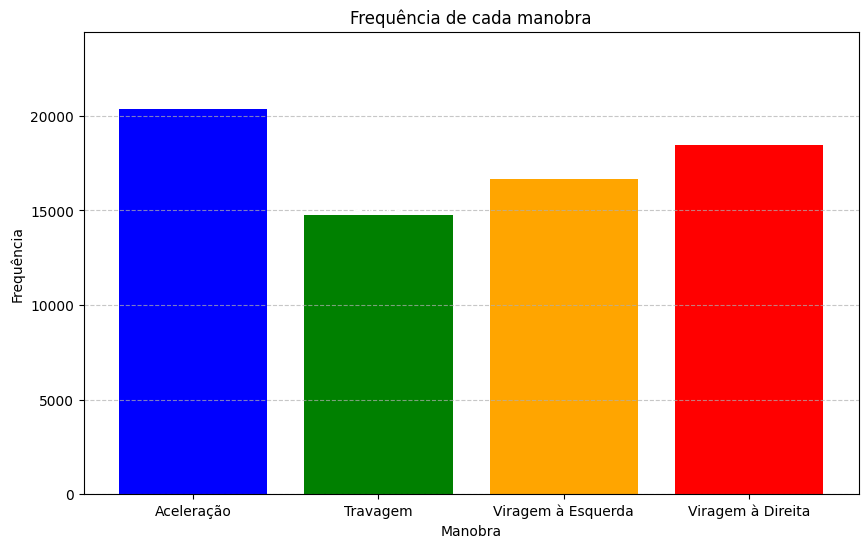

In [184]:

def count_manobras(accelY, breakY, turnLeftXn, turnRightXn):
    manobras = {
        'Aceleração': np.count_nonzero(accelY),
        'Travagem': np.count_nonzero(breakY),
        'Viragem à Esquerda': np.count_nonzero(turnLeftXn),
        'Viragem à Direita': np.count_nonzero(turnRightXn)
    }
    
    return manobras

#calcula a disntancia entre dois pontos
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # +- raio da terra em metros
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

#distancia total percorrida
def total_distance(lat, lon):
    distance = 0.0
    for i in range(1, len(lat)):
        distance += haversine(lat[i], lon[i], lat[i - 1], lon[i - 1])
    return distance


#print distance total percorrida em km arrendondado a 2 casas decimais
print(f'Distância total percorrida: {total_distance(latitude, longitude) / 1000:.2f} km')

#print numero total de leituras de manobras
print(f'Numero Total de Manobras: {count_manobras(accelY, breakY, turnLeftXn, turnRightXn)} manobras')







manobras = count_manobras(accelY, breakY, turnLeftXn, turnRightXn)

manobras_labels = list(manobras.keys())
manobras_quantidades = list(manobras.values())


cores = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(10, 6))
bars = plt.bar(manobras_labels, manobras_quantidades, color=cores)

for bar, quantidade in zip(bars, manobras_quantidades):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.1, quantidade,
             ha='center', va='bottom', color='white', fontsize=12)

plt.xlabel('Manobra')
plt.ylabel('Frequência')
plt.title('Frequência de cada manobra')
plt.ylim(0, max(manobras_quantidades) * 1.2)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Show manovers on Google Map

In [185]:
positions = np.array(list(zip(latitude, longitude)))
manover_accelY = y[:, 2]
manover_breakY = y[:, 3]
manover_turnRightXn = y[:, 0]
manover_turnLeftXn = y[:, 1]
gyrPositiveZn = y[:, 10]
gyrNegativeZn = y[:, 11]
save_manovers_positions_to_csv_file(positions, manover_accelY, "accelY.csv")
save_manovers_positions_to_csv_file(positions, manover_breakY, "breakY.csv")
save_manovers_positions_to_csv_file(positions, manover_turnRightXn, "turnRightX.csv")
save_manovers_positions_to_csv_file(positions, manover_turnLeftXn, "turnLeftX.csv")
save_manovers_positions_to_csv_file(positions, gyrPositiveZn, "gyrPositZ.csv")
save_manovers_positions_to_csv_file(positions, gyrNegativeZn, "gyrNegZ.csv")

## **Plot Manovers**

In [186]:
map = folium.Map(location=[np.mean(latitude), np.mean(longitude)], zoom_start=10)


marker_cluster = MarkerCluster().add_to(map)

for i in range(len(positions)):
    if manover_accelY[i] == 1:
        folium.Marker([positions[i][0], positions[i][1]], icon=folium.Icon(color='blue'),popup=f'Aceleração').add_to(marker_cluster)
    if manover_breakY[i] == 1:
        folium.Marker([positions[i][0], positions[i][1]], icon=folium.Icon(color='red'),popup=f'Travagem').add_to(marker_cluster)
    if manover_turnRightXn[i] == 1:
        folium.Marker([positions[i][0], positions[i][1]], icon=folium.Icon(color='green'),popup=f'Viragem à Esquerda').add_to(marker_cluster)
    if manover_turnLeftXn[i] == 1:
        folium.Marker([positions[i][0], positions[i][1]], icon=folium.Icon(color='orange'),popup=f'Viragem à Direita').add_to(marker_cluster)
   
    if gyrPositiveZn[i] == 1:
        folium.Marker([positions[i][0], positions[i][1]], icon=folium.Icon(color='purple'),popup=f'Curva à Direita').add_to(marker_cluster)
    if gyrNegativeZn[i] == 1:
        folium.Marker([positions[i][0], positions[i][1]], icon=folium.Icon(color='black'),popup=f'Curva à Esquerda').add_to(marker_cluster)


map.save('runtime_saves/manobras.html')

map




# **MODEL**

## Separate data in train and test

In [187]:
# x_train, x_test = split_train_test(x, test_size=0.2)

# y_train, y_test = split_train_test(y, test_size=0.2)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

#shape
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(26346, 12) (26346, 12)
(8783, 12) (8783, 12)


## Create the input tensor data

In [188]:
train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

print(train.shape)
print(test.shape)

np.savetxt("runtime_saves/train&test/x_train.csv", x_train, delimiter=',', fmt='%.9f')
np.savetxt("runtime_saves/train&test/x_test.csv", x_test, delimiter=',', fmt='%.9f')
np.savetxt("runtime_saves/train&test/y_train.csv", y_train, delimiter=',', fmt='%.0i')
np.savetxt("runtime_saves/train&test/y_test.csv", y_test, delimiter=',', fmt='%.0i')

np.savetxt("runtime_saves/train&test/train.csv", train.reshape(train.shape[0], train.shape[2]), delimiter=',', fmt='%.9f')
np.savetxt("runtime_saves/train&test/test.csv", test.reshape(test.shape[0], test.shape[2]), delimiter=',', fmt='%.9f')

(26346, 1, 12)
(8783, 1, 12)


## **Create Model**

### #TODO

In [189]:

from keras.optimizers import Adam,RMSprop
from keras.initializers import HeNormal
from keras.regularizers import l2
K.clear_session()
dropout1 = 0.2
dropout2 = 0.1
learning_rate = 0.001
l2_reg = 0.001
init = HeNormal()


# conv1D and LSTM model 
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, 12)))
model.add(BatchNormalization())
model.add(Dropout(dropout1))
model.add(LSTM(64, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(dropout2))
model.add(LSTM(64))
model.add(BatchNormalization())
model.add(Dropout(dropout2))
model.add(Dense(12, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])




## **Train Model**

Train the model with the training data and validate it with the test data.

Training configuration:
- 30 epochs
- Batch size of 64
- Early stopping to prevent overfitting
- Learning rate reduction on plateau
- Model checkpoint to save the best model based on validation loss

In [190]:
# best callback for the model
best_model_file = 'runtime_saves/models/model.keras'
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# reduce learning rate callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
# fit the model
history = model.fit(train, y_train, epochs=30, batch_size=32 , validation_data=(test, y_test), verbose=1, callbacks=[best_model, early_stop])

Epoch 1/30
818/824 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1326 - loss: 0.3599
Epoch 1: val_loss improved from inf to 0.02518, saving model to runtime_saves/models/model.keras
824/824 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.1328 - loss: 0.3582 - val_accuracy: 0.1954 - val_loss: 0.0252
Epoch 2/30
817/824 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2015 - loss: 0.0297
Epoch 2: val_loss improved from 0.02518 to 0.01474, saving model to runtime_saves/models/model.keras
824/824 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2016 - loss: 0.0297 - val_accuracy: 0.2036 - val_loss: 0.0147
Epoch 3/30
818/824 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2193 - loss: 0.0213
Epoch 3: val_loss improved from 0.01474 to 0.01247, saving model to runtime_saves/models/model.keras
824/824 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2193 - loss: 0.0213 - val_accuracy: 0.2315 - val_loss: 0.0125
Epoch 4/30
820/824 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2228 - loss: 0.0184
Epoch

# **RESULTS**

## Evaluate the model

In [191]:
pred = model.predict(test)
print(pred)

275/275 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
[[1.0099375e-05 8.9535097e-06 3.3078024e-05 ... 2.2439592e-05
  1.2400678e-04 1.0896754e-04]
 [1.1823087e-05 5.3512857e-05 9.3873641e-05 ... 5.0127082e-06
  1.1745935e-05 2.6064537e-05]
 [8.5971833e-06 1.8239501e-06 2.7405528e-07 ... 1.9581309e-07
  2.6422520e-05 8.9751552e-07]
 ...
 [1.0902788e-05 3.6941456e-06 5.0204754e-04 ... 5.5781693e-06
  4.8223115e-05 8.9950445e-06]
 [1.9266315e-07 1.3257247e-08 7.4489526e-07 ... 5.3127646e-08
  6.3134209e-08 3.5145717e-08]
 [1.6679336e-07 1.7594415e-08 5.1065621e-07 ... 8.4175982e-09
  1.4004875e-08 3.0866778e-09]]


In [192]:
pred = np.round(pred).astype(int)
print(pred)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [193]:
pred = np.argmax(pred, axis=1)
print(pred)
pred.shape

[0 0 0 ... 0 0 0]


(8783,)

In [194]:
# Check shapes of y_test and pred
print(y_test.shape)  # Should be (n_samples, 12)
print(pred.shape)    # Should be (n_samples, 12)

# Check unique values to ensure binary classification
print(np.unique(y_test))
print(np.unique(pred))


(8783, 12)
(8783,)
[0 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11]


## Confusion Matrix

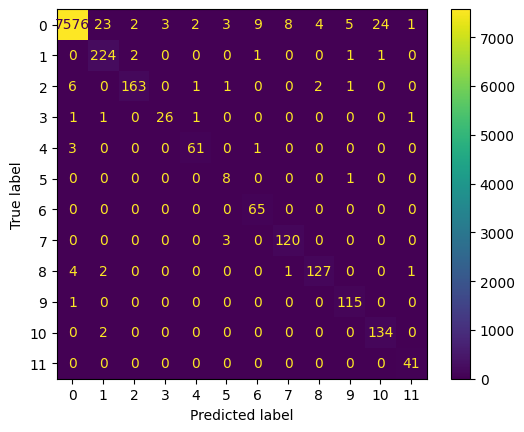

In [215]:

# clabels = ['AccelY', 'BreakY', 'TurnRightX', 'Turn LeftX', 'PositiveZ', 'NegativeZ', 'GyrPositiveX', 'GyrNegativeX', 'GyrPositiveY', 'GyrNegativeY', 'GyrPositiveZ', 'GyrNegativeZ']

# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = clabels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat)
 
# display matrix
cm_display.plot()
plt.show()


## Performance Metrics

- Accuracy = $\large = \frac{Correct~Predictions}{All~Predictions}$
- Precision for a given class = $\large = \frac{Correct~Predictions~for~the~Class}{All~Predictions~for~the~Class}$   
- Recall for a given class = $\large = \frac{Correct~Predictions~for~the~Class}{All~Instances~of~the~Class}$  

- Averaging is a way to get a single number for multiclass. Depending on the importance one wants to give to minority classes: 
    - Macro average: Compute the metric for each class, and returns the average without considering the proportion for each class in the dataset. For instance:

        Precision = $\large = \frac{P_{class 1} ~+~ P_{class 2} ~+~ ... ~+~ P_{class n}}{N}$   
    
    - Weighted average: Compute the metric for each class, and returns the average considering the proportion (weighted) for each class in the dataset. For instance:

        Precision = $\large = \frac{N_1 ~*~ P_{class 1} ~+~ N_2 ~*~ P_{class 2} ~+~ ... ~+~ N_n ~*~ P_{class n}}{N}$

In [221]:
# Calculates performance metrics
acc = accuracy_score(y_true =  y_test, y_pred = pred)
print(f'Accuracy : {np.round(acc*100,2)}%')
          
precision = precision_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'Precision - Macro: {np.round(precision*100,2)}%')

recall = recall_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'Recall - Macro: {np.round(recall*100,2)}%')

f1 = f1_score(y_true =  y_test, y_pred = pred, average='macro')
print(f'F1-score - Macro: {np.round(f1*100,2)}%')

precision = precision_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'Precision - Weighted: {np.round(precision*100,2)}%')

recall = recall_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'Recall - Weighted: {np.round(recall*100,2)}%')

f1 = f1_score(y_true =  y_test, y_pred = pred, average='weighted')
print(f'F1-score - Weighted: {np.round(f1*100,2)}%')

TypeError: Singleton array array(165, dtype=int64) cannot be considered a valid collection.

# **TEST THE NETWORK**

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Historico de train')
plt.xlabel('Epocas de train')
plt.ylabel('Função custo')
plt.legend(['Erro train', 'Erro test'])
plt.show()

In [ ]:
test[0]
test.shape

In [ ]:
i = 0
for i in range(100):
    a = x_test[i]
    b = a.reshape(1, 1, 12)

    # Make predictions on new data
    prediction = model.predict(b)
    #predicted_class = label_encoder.inverse_transform(prediction)[0]

    np.round(prediction, decimals=1, out=prediction)
    np.round(x_test[i], decimals=1, out=x_test[i])
    #print("Value:", newArray[i + start])
    if (np.sum(y_test[i]) > 0):
      print("X [:", x_test[i])
      print("Y [:", y_test[i])
      print("PC:", prediction)
      print (i)
    i = 1 + 1
#PREDICTIONS WITH COLAB MODEL
#prediction = model.predict(teste)
#print("Predicted class:", prediction)
#print("Predicted class:", predicted_class)

In [ ]:
test_value = np.array([0., 0.363, 0.313, 0., 0., 0.31, 0.393, 0., 0., 0.244, 0.247, 0.])
test_value = test_value.reshape(1, 1, 12)

# Make predictions on new data
prediction = model.predict(test_value)
np.round(prediction, decimals=2, out=prediction)

print("Value    :", test_value[0][0])
print("Predicted:", prediction[0])

# **TESTE**

In [ ]:
def test_model(model, test_data, test_labels, start, end):
    predictions = model.predict(test_data[start:end])

    plt.figure(figsize=(10, 6))
    plt.plot(test_labels[start:end], 'ro-', label='True values')
    plt.plot(predictions, 'bx-', label='Predicted values')
    plt.title('Predictions vs True values')
    plt.legend()
    plt.show()
    
    return predictions

predictions = test_model(model, test, y_test, 0, 30)









# **SAVE THE MODEL**

In [ ]:
import os
import datetime

model_name = 'lstm_model_Conv_' + datetime.datetime.now().strftime("%Y-%m-%d %HH%Mm%Ss") + '.h5'

# Save the model in runtime_saves/models folder
model_lstm.save(os.path.join(".", 'runtime_saves', 'models', model_name))

In [ ]:
# model sumary
model_lstm.summary()